In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras

# **Import data / split**

In [3]:
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
rescale = Rescaling(scale=1.0/255)

In [4]:
train = tf.keras.utils.image_dataset_from_directory(
    "../input/xray-bodypart/train",
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=42,
    validation_split=.2,
    subset="training"
)
train = train.map(lambda image,label:(rescale(image),label))

Found 1606 files belonging to 22 classes.
Using 1285 files for training.


2023-02-03 09:27:42.441805: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-03 09:27:42.539332: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-03 09:27:42.540136: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-03 09:27:42.543399: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [5]:
val = tf.keras.utils.image_dataset_from_directory(
    "../input/xray-bodypart/train",
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=42,
    validation_split=.2,
    subset="validation"
)
val = val.map(lambda image,label:(rescale(image),label))

Found 1606 files belonging to 22 classes.
Using 321 files for validation.


In [6]:
import tensorflow.keras.layers as layers

data_augmentation = keras.Sequential(
  [
    #layers.experimental.preprocessing.Rescaling(1./255),
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                         input_shape=(256,256,1)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    tf.keras.layers.experimental.preprocessing.RandomContrast(factor=(0.8, 1.4))
  ]
)

2023-02-03 09:29:35.821177: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


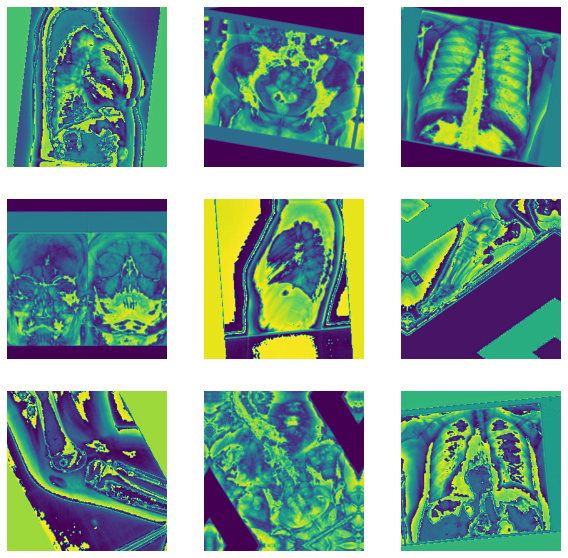

In [7]:
import matplotlib.pyplot as plt
#class_names = train.class_names
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)*255
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        #plt.title(class_names[labels[i]])
        #plt.title(labels[i])
        plt.axis("off")

# **Make model**

In [8]:
model = tf.keras.applications.efficientnet.EfficientNetB3(
    include_top=True,
    weights=None,
    input_shape=(256,256,1),
    classes=22,
    classifier_activation='softmax'
)
model.summary()

Model: "efficientnetb3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 256, 256, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 256, 256, 1)  3           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 257, 1)  0           normalization[0][0]              
_____________________________________________________________________________________

In [9]:
import tensorflow_addons as tfa
f1m = tfa.metrics.F1Score(
    num_classes= 22,
    average= "micro",
    name = 'f1_micro',
)
f1M = tfa.metrics.F1Score(
    num_classes= 22,
    average= "macro",
    name = 'f1_macro',
)
model.compile(optimizer="adam",metrics=[f1m,f1M,"accuracy"],loss="categorical_crossentropy")

# **Training**

In [10]:
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=25,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)

In [11]:
model.fit(train,validation_data=val,epochs=200,callbacks=[earlystopping])

Epoch 1/200


2023-02-03 09:43:17.848209: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


41/41 [==============================] - 45s 608ms/step - loss: 3.6135 - f1_micro: 0.3837 - f1_macro: 0.0565 - accuracy: 0.3837 - val_loss: 2.3450 - val_f1_micro: 0.4268 - val_f1_macro: 0.0272 - val_accuracy: 0.4268
Epoch 2/200
41/41 [==============================] - 22s 524ms/step - loss: 2.6018 - f1_micro: 0.4607 - f1_macro: 0.0526 - accuracy: 0.4607 - val_loss: 2.7353 - val_f1_micro: 0.4268 - val_f1_macro: 0.0272 - val_accuracy: 0.4268
Epoch 3/200
41/41 [==============================] - 22s 528ms/step - loss: 2.2261 - f1_micro: 0.4856 - f1_macro: 0.0754 - accuracy: 0.4856 - val_loss: 3.0878 - val_f1_micro: 0.4268 - val_f1_macro: 0.0272 - val_accuracy: 0.4268
Epoch 4/200
41/41 [==============================] - 22s 524ms/step - loss: 2.0837 - f1_micro: 0.4833 - f1_macro: 0.0834 - accuracy: 0.4833 - val_loss: 3.2215 - val_f1_micro: 0.4268 - val_f1_macro: 0.0272 - val_accuracy: 0.4268
Epoch 5/200
41/41 [==============================] - 22s 525ms/step - loss: 1.9562 - f1_micro: 0.497

# **Prediction**

In [23]:
test = tf.keras.utils.image_dataset_from_directory(
    "../input/xray-bodypart/test",
    labels=None,
    color_mode='grayscale',
    batch_size=32,
    image_size=(256, 256),
    shuffle=False,
    seed=42,
)
list_path = test.file_paths
index = [int(x.split("/")[-1].split(".")[0]) for x in list_path]
test = test.map(lambda image:(rescale(image)))

Found 743 files belonging to 1 classes.


In [18]:
prediction = model.predict(test)
pred = np.argmax(prediction,axis=-1)
pred_right_index = np.zeros_like(pred)
for i,idx in enumerate(index):
    pred_right_index[idx] = pred[i]
pred_right_index

array([ 9,  0, 11,  3,  3, 14,  3,  5,  3,  0,  0,  3,  3,  3, 11, 17,  3,
        3,  1, 14, 18,  3,  3,  3,  3, 21, 11,  3, 11,  0,  3,  9,  3,  3,
        3, 19, 13,  5,  3,  3,  8,  3,  3,  0,  3, 17,  3,  6,  6,  9,  3,
        3,  3,  8,  3, 11, 12,  0, 15,  3,  3, 16,  1, 17,  3,  3,  3,  3,
        3,  3, 11,  3,  3,  3,  0,  3,  1,  3,  0,  0, 15, 21,  6,  3,  3,
        3,  3, 15,  3,  3,  3,  3,  3, 14,  3,  0,  3,  3,  5, 11,  3,  3,
        3, 20,  0,  0,  6,  5, 14,  3,  0,  3,  3, 14, 11,  5,  3,  3,  3,
        4,  5,  9, 11,  3,  0, 18, 16,  3,  3,  2, 11, 14,  3, 15, 21,  8,
        3,  3, 15,  9, 11, 14,  5,  1, 15,  9, 18,  3,  3,  3, 13,  3, 14,
        3, 14,  7, 11,  3,  3,  3,  6, 11,  3,  3,  8,  3,  0,  0,  3,  3,
        3, 21,  3,  3,  5,  3,  3,  3, 13,  6, 12, 11,  1,  3, 12,  2, 15,
        0,  6,  3, 15, 14,  3,  3, 13,  2,  3, 21,  3, 13,  9,  4,  3,  3,
        3,  3, 20,  3, 11,  3,  3,  3,  5,  0,  3, 17,  3,  0,  3,  0, 11,
        3,  0, 11,  9,  3

# **Submission**

In [ ]:
test_ds = pd.read_csv("../input/unifesp-x-ray-body-part-classifier/sample_submission.csv")
test_ds.head()

In [ ]:
test_ds["Target"] = pred_right_index
test_ds.head()

In [ ]:
test_ds.to_csv("./submission.csv",index=False)